# Image Clasifier (Cats and Dogs)

### Problem Statement: 
In this repository, I aim to develop a robust image classification model capable of distinguishing between images of cats and dogs. By leveraging advanced machine learning techniques, my objective is to accurately predict whether a given image, containing a single object, belongs to the 'cat' class or the 'dog' class.

### Dataset Collection:

The foundation of this project rests on the rich dataset provided by "The Oxford-IIIT Pet Dataset." This comprehensive dataset has been meticulously curated to facilitate the training and evaluation of machine learning models for pet image classification. The dataset comprises 37 distinct categories, each representing a specific breed of pets. Remarkably, there are approximately 200 images available for each class, ensuring a substantial and diverse range of examples.

The strength of this dataset lies in its authenticity and diversity. The images encompass a wide array of scales, poses, and lighting conditions, mirroring the real-world variability encountered in pet photography. To facilitate accurate predictions, every image is associated with a ground truth annotation that includes crucial information such as the breed of the pet, the region of interest (ROI) encompassing the head, and a detailed pixel-level trimap segmentation.

The dataset's emphasis on meticulous annotation and its ample variation make it an ideal resource for training and testing robust image classification algorithms. By harnessing this dataset's inherent complexity and depth, I seek to develop a model that goes beyond basic categorization, enabling the accurate identification of whether a given image portrays a cat or a dog.

For detailed information about the dataset and access to its resources, interested individuals can visit the dataset's official page at https://www.robots.ox.ac.uk/~vgg/data/pets/. This repository aims to harness the potential of this dataset to create an effective and precise image classification solution for the pet classification problem.

### Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.models import load_model
%matplotlib inline

### Implementing GPU acc and eliminating chances of OOM errors

This configures TensorFlow to dynamically allocate GPU memory as needed, which helps optimize memory usage when working with deep learning models and prevents the GPU from grabbing all available memory at once.

"OOM" stands for "Out of Memory." An "OOM error" occurs when a computer program or system attempts to allocate more memory (RAM or GPU memory) than is available. This often happens when a program or process requires more memory to perform its tasks than what the system can provide.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Data Checking and transformation

During the initial stages of data exploration, I worked with a dataset containing images of various breeds of dogs and cats. The dataset was accompanied by an annotation folder containing XML files, which I combined with the images. I utilized the xml.etree.ElementTree module to extract essential information such as filename, width, height, class, and bounding box coordinates (xmin, ymin, xmax, ymax). This information was then structured into a comprehensive CSV file named 'info.csv', providing a consolidated overview of the dataset.

Upon closer inspection of the dataset, I recognized the importance of data quality. To ensure a more standardized dataset, I made the decision to remove images with a file size of less than 10 KB. This approach, while not without limitations, helped eliminate images that might have been of low resolution or compromised quality. This action contributed to the normalization of the dataset and resulted in improved image sizes.

Furthermore, I classified the dataset into two main classes: 'Class 0' representing cats and 'Class 1' representing dogs. This classification was based on the available class labels and annotations associated with each image.

To streamline the dataset and enhance its quality, these preprocessing steps collectively set the foundation for subsequent analysis and model development.

In [3]:
image_folder = os.path.join(os.getcwd(),'images')

In [4]:
img= cv2.imread(os.path.join(image_folder,'0','Abyssinian_1.jpg'))
img.shape

(400, 600, 3)

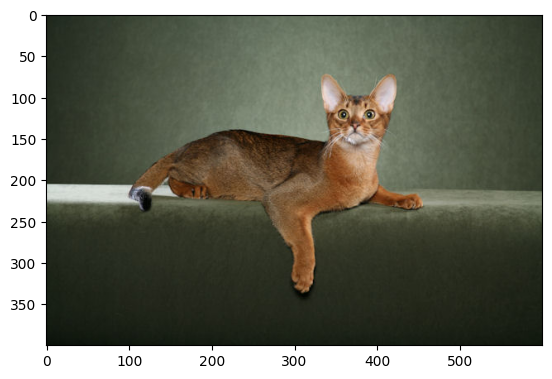

In [5]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
cv2.imread(os.path.join(image_folder,'0','Abyssinian_1.jpg'))

array([[[27, 38, 30],
        [27, 38, 30],
        [27, 38, 30],
        ...,
        [38, 51, 43],
        [36, 49, 41],
        [35, 48, 40]],

       [[26, 37, 29],
        [26, 37, 29],
        [27, 38, 30],
        ...,
        [38, 51, 43],
        [37, 50, 42],
        [35, 48, 40]],

       [[26, 37, 29],
        [26, 37, 29],
        [26, 37, 29],
        ...,
        [39, 52, 44],
        [38, 51, 43],
        [36, 49, 41]],

       ...,

       [[11, 19, 12],
        [10, 18, 11],
        [10, 18, 11],
        ...,
        [12, 23, 15],
        [12, 23, 15],
        [12, 23, 15]],

       [[11, 19, 12],
        [10, 18, 11],
        [10, 18, 11],
        ...,
        [12, 23, 15],
        [12, 23, 15],
        [12, 23, 15]],

       [[11, 19, 12],
        [10, 18, 11],
        [ 9, 17, 10],
        ...,
        [12, 23, 15],
        [12, 23, 15],
        [12, 23, 15]]], dtype=uint8)

### Data Preprocessing

In [7]:
data=tf.keras.utils.image_dataset_from_directory(image_folder,image_size=(256,256),batch_size=16)

Found 7165 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(16, 256, 256, 3)

In [9]:
batch[1]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

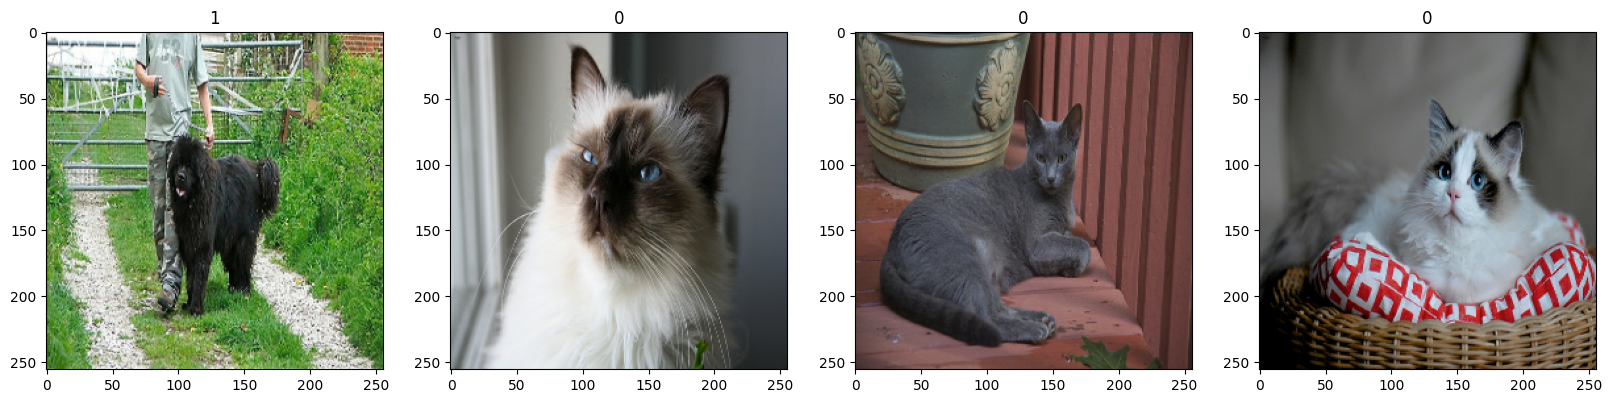

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
scaled_data = data.map(lambda x,y: (x/255, y))
batch = scaled_data.as_numpy_iterator().next()
batch[0].max()

1.0

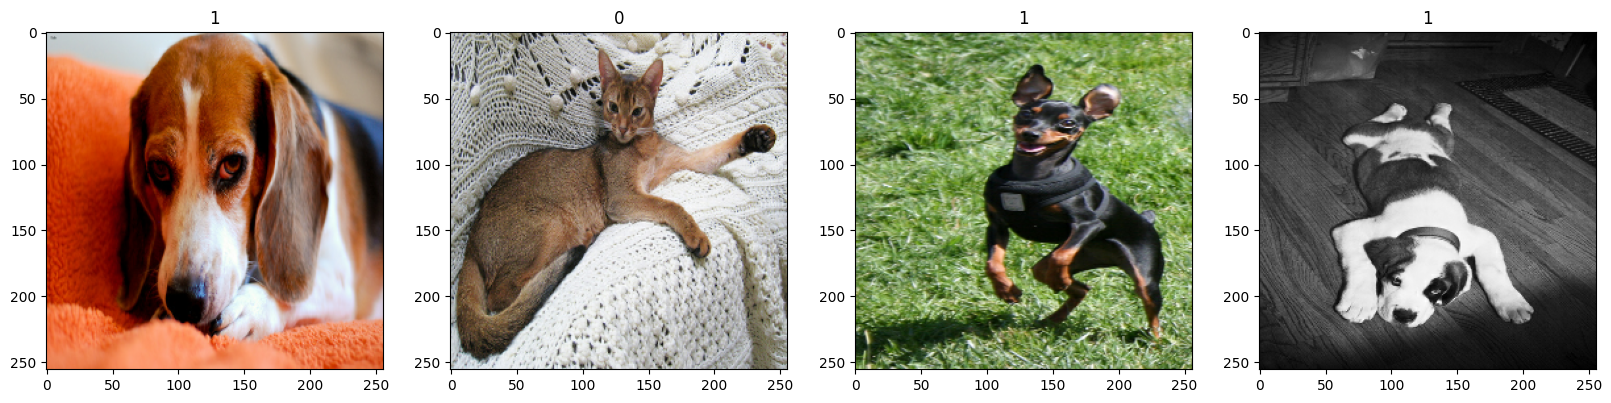

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Spliting data into training, testing and validating sets

In [13]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1

In [14]:
len(scaled_data)

448

In [15]:
train_size+val_size+test_size

448

In [16]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

### Building Deep Learning Model

Now comes the most exciting phase of the process - "Building a Deep Learning Model". In this phase, I leveraged Keras's MobileNetV2 as the foundation for our model. With an image size of (256,256), I set the include_top parameter to False and narrowed down the number of classes to 2, which suits our specific case. To finalize our custom model architecture, I incorporated a GlobalAveragePooling2D() layer, which aids in reducing dimensionality and retaining important features, followed by a Dense(1) layer for the final output. This approach allows us to harness the power of transfer learning from MobileNetV2 while tailoring the model for our binary classification task, ensuring efficient training and accurate predictions.

In [17]:
base_model= tf.keras.applications.MobileNetV2(input_shape=(256,256,3),
                                              include_top=False,
                                              weights='imagenet',
                                              classes=2
)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

In [18]:
for image, _ in train.take(1):
    pass
feature_batch=base_model(image)
feature_batch

<tf.Tensor: shape=(16, 8, 8, 1280), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 1.7384763 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 2.25916   ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 2.1943917 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 1.3170261 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.88244295],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 1.5054698 ],
         [0.        , 0.        , 1.9878182 , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.      

In [19]:
base_model.trainable = False

In [20]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1)
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Traing Model

In [23]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
hist = model.fit(train,
                    epochs=10,
                    validation_data=val)
acc = hist.history['accuracy']
acc

Epoch 1/10
313/313 [==============================] - 473s 1s/step - loss: 0.4045 - accuracy: 0.7949 - val_loss: 0.2009 - val_accuracy: 0.9681
Epoch 2/10
313/313 [==============================] - 521s 2s/step - loss: 0.1483 - accuracy: 0.9744 - val_loss: 0.0990 - val_accuracy: 0.9868
Epoch 3/10
313/313 [==============================] - 650s 2s/step - loss: 0.0867 - accuracy: 0.9838 - val_loss: 0.0626 - val_accuracy: 0.9903
Epoch 4/10
313/313 [==============================] - 576s 2s/step - loss: 0.0629 - accuracy: 0.9872 - val_loss: 0.0476 - val_accuracy: 0.9910
Epoch 5/10
313/313 [==============================] - 355s 1s/step - loss: 0.0512 - accuracy: 0.9890 - val_loss: 0.0404 - val_accuracy: 0.9917
Epoch 6/10
313/313 [==============================] - 343s 1s/step - loss: 0.0433 - accuracy: 0.9912 - val_loss: 0.0305 - val_accuracy: 0.9944
Epoch 7/10
313/313 [==============================] - 304s 969ms/step - loss: 0.0383 - accuracy: 0.9914 - val_loss: 0.0294 - val_accuracy: 0.9

[0.7949281334877014,
 0.97444087266922,
 0.9838258624076843,
 0.9872204661369324,
 0.9890175461769104,
 0.9912140369415283,
 0.9914137125015259,
 0.9922124743461609,
 0.992611825466156,
 0.9930111765861511]

### Performance Plots

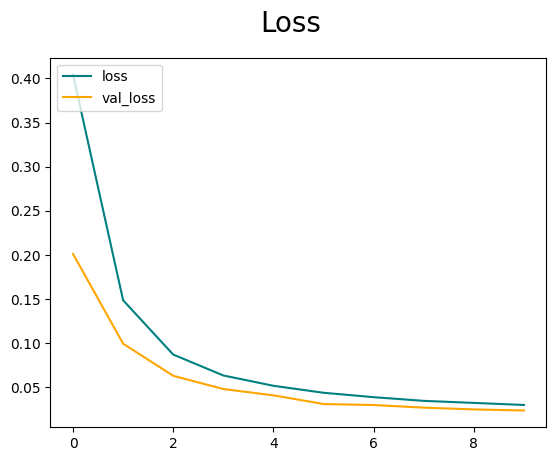

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

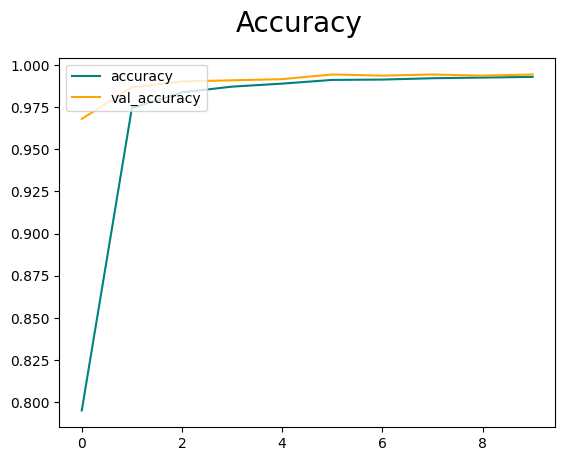

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Predicting with random images of dogs and cats

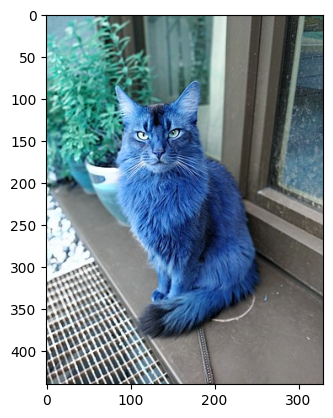

In [27]:
img= cv2.imread(os.path.join(image_folder,'test_cat1.jpg'))
img.shape
plt.imshow(img)
plt.show()

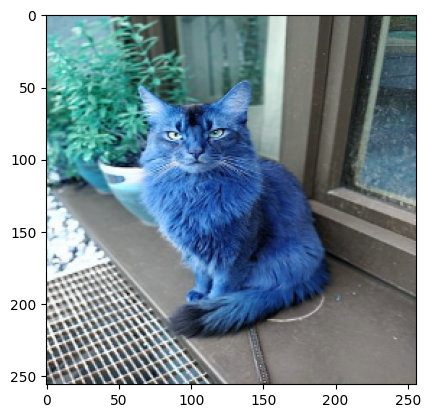

In [28]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
prediction = model.predict(np.expand_dims(resize/255, 0))
prediction

1/1 [==============================] - 1s 1s/step


array([[-6.875608]], dtype=float32)

In [30]:
if prediction > 0.5: 
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Cat


In [31]:
model.save(os.path.join('models','imageclassifier.h5'))

d:\VSCode\Datascience\Projects\ImageClassifier-Dog-Cat\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
